# Swarm Intelligence for Autonomous Microgrid Energy Balancing
## Problem Statement
Modern microgrids integrate renewable energy sources like solar and wind, but their inherently variable output causes frequent mismatches between supply and demand. Traditional centralized control methods are slow to respond, require high communication overhead, and are vulnerable to single-point failures. The challenge is to design a decentralized, adaptive, and scalable approach that can automatically balance energy generation, storage, and consumption in real time — without relying on a central controller.

## Proposed Solution
Use swarm intelligence algorithms (e.g., Particle Swarm Optimization or Ant Colony Optimization) to coordinate distributed energy resources in a microgrid. In this approach:

*   Each node (generator, storage unit, or load) acts as an intelligent agent that shares minimal local information.

*   Agents iteratively update their decisions on energy production, consumption, or storage by following simple rules inspired by swarm behavior (like flocking birds or ants finding food).

*   The system converges to a global balance of energy through self-organization, reducing reliance on centralized control.

## Key Benefits:


*   Real-time adaptability: Quickly responds to changing energy demand or renewable fluctuations.

*   Decentralization: Eliminates single-point failure risks.

*   Scalability: Works as more nodes or resources are added.

*   Efficiency: Optimizes power flow and minimizes losses.










In [1]:
!pip -q install pyswarms pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyswarms as ps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.0 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("energy_dataset_.csv")

needed = [
    'Energy_Production_MWh',
    'Energy_Consumption_MWh',
    'Energy_Storage_Capacity_MWh',
    'Storage_Efficiency_Percentage'
]
missing = [c for c in needed if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

df = df.copy()
df['eff'] = df['Storage_Efficiency_Percentage'] / 100.0

# Take a random sample of 200 nodes
np.random.seed(42)
sample_n = 200
idx = np.random.choice(len(df), size=sample_n, replace=False)
d = df.iloc[idx].reset_index(drop=True)

gen  = d['Energy_Production_MWh'].to_numpy()
load = d['Energy_Consumption_MWh'].to_numpy()
cap  = d['Energy_Storage_Capacity_MWh'].to_numpy()
eff  = d['eff'].to_numpy()


In [3]:
baseline_abs = np.abs(gen - load).sum()
baseline_sq  = np.sum((gen - load) ** 2)

print("Nodes:", len(d))
print(f"Baseline abs mismatch: {baseline_abs:.2f}")
print(f"Baseline squared mismatch: {baseline_sq:.2f}")


Nodes: 200
Baseline abs mismatch: 33523034.09
Baseline squared mismatch: 8470777047816.24


In [4]:
def objective_single(x, metric="sq", sign="+", cap_override=None):
    x = np.clip(x, 0, cap_override if cap_override is not None else cap)
    if sign == "+":
        net_after = gen - load + x * eff
    else:
        net_after = gen - load - x * eff

    if metric == "abs":
        return np.abs(net_after).sum()
    else:  # squared mismatch
        return np.sum(net_after ** 2)

def objective_swarm(X, metric="sq", sign="+", cap_override=None):
    return np.array([objective_single(x, metric=metric, sign=sign, cap_override=cap_override) for x in X])


In [5]:
dims = len(d)
lb = np.zeros(dims)
ub = cap.copy()
bounds = (lb, ub)

options = {'c1': 2.0, 'c2': 2.0, 'w': 0.7}

# ⚡ Configurable parameters
chosen_metric = "abs"   # "abs" or "sq"
chosen_sign   = "+"     # "+" or "-"
cap_factor    = 1       # use 10 for scenario test

cap_used = cap * cap_factor

optimizer = ps.single.GlobalBestPSO(
    n_particles=100, dimensions=dims, options=options, bounds=(lb, cap_used)
)

best_cost, best_pos = optimizer.optimize(
    lambda X: objective_swarm(X, metric=chosen_metric, sign=chosen_sign, cap_override=cap_used),
    iters=200, verbose=False
)


In [6]:
optimized_storage = np.clip(best_pos, 0, cap_used)

if chosen_sign == "+":
    net_after = gen - load + optimized_storage * eff
else:
    net_after = gen - load - optimized_storage * eff

optimized_abs = np.abs(net_after).sum()
optimized_sq  = np.sum(net_after ** 2)

improve_abs = baseline_abs - optimized_abs
improve_pct_abs = improve_abs / baseline_abs * 100

improve_sq = baseline_sq - optimized_sq
improve_pct_sq = improve_sq / baseline_sq * 100

print("Some optimized storage decisions (MWh):", optimized_storage[:10])
print(f"\n--- Absolute mismatch ---")
print(f"Baseline:  {baseline_abs:.2f}")
print(f"Optimized:{optimized_abs:.2f}")
print(f"Improvement: {improve_abs:.2f}  ({improve_pct_abs:.6f}%)")

print(f"\n--- Squared mismatch ---")
print(f"Baseline:  {baseline_sq:.2f}")
print(f"Optimized:{optimized_sq:.2f}")
print(f"Improvement: {improve_sq:.2f}  ({improve_pct_sq:.6f}%)")


Some optimized storage decisions (MWh): [ 429.94442369 5198.82010015  857.21837451  792.18906531 1195.09767641
 1177.69897754 2227.74085456 4609.75408662  834.41484128 4234.23465885]

--- Absolute mismatch ---
Baseline:  33523034.09
Optimized:33508103.14
Improvement: 14930.95  (0.044539%)

--- Squared mismatch ---
Baseline:  8470777047816.24
Optimized:8475305065654.65
Improvement: -4528017838.41  (-0.053455%)


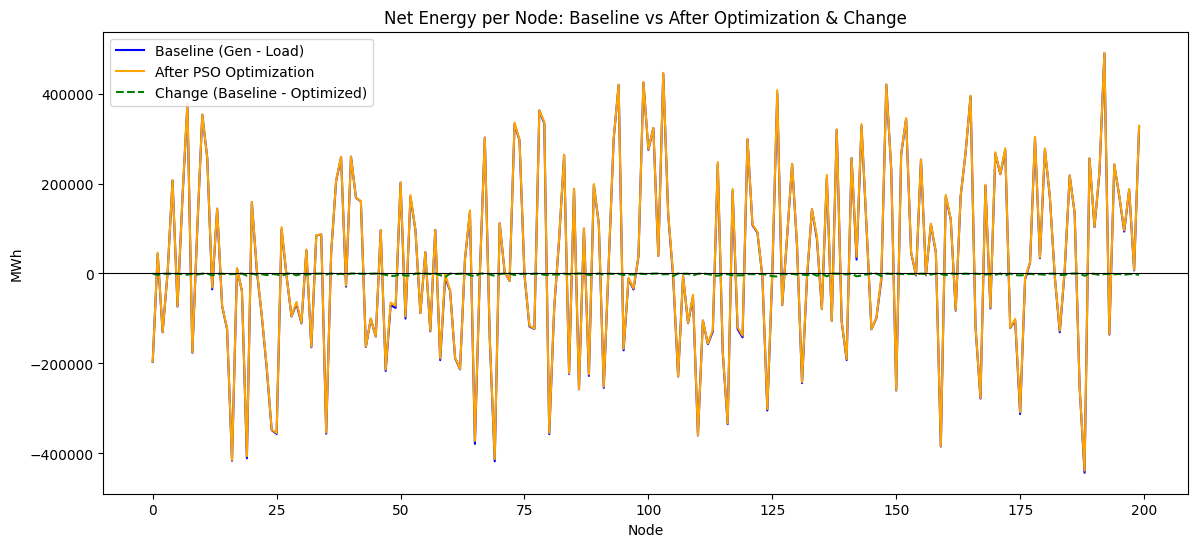

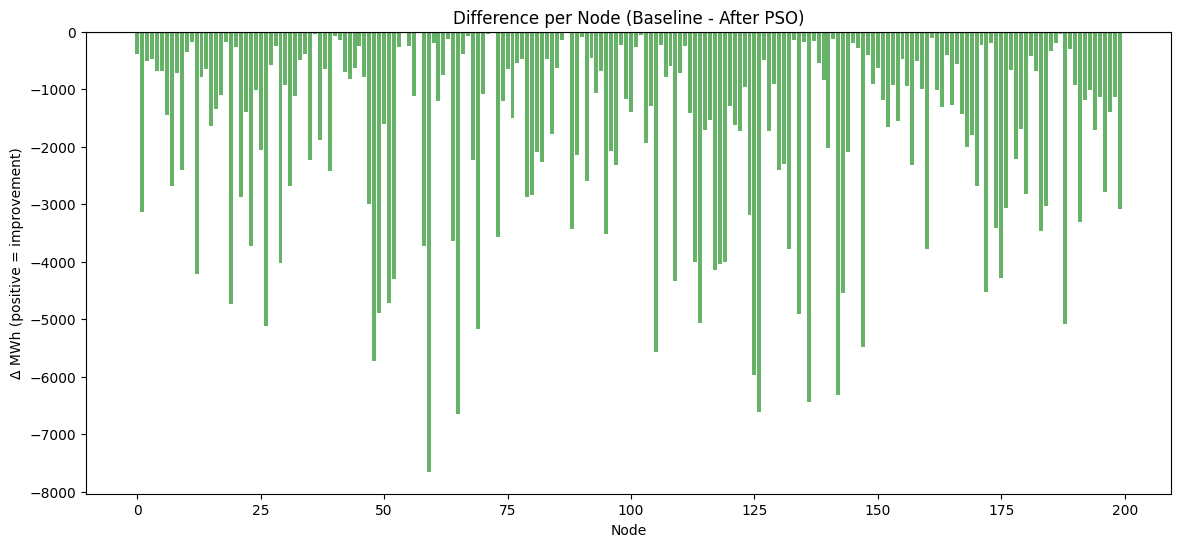

In [7]:
x = np.arange(len(gen))
baseline_net = gen - load
optimized_net = net_after
difference = baseline_net - optimized_net

plt.figure(figsize=(14,6))
plt.plot(x, baseline_net, color='blue', label='Baseline (Gen - Load)')
plt.plot(x, optimized_net, color='orange', label='After PSO Optimization')
plt.plot(x, difference, color='green', linestyle='--', label='Change (Baseline - Optimized)')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Net Energy per Node: Baseline vs After Optimization & Change')
plt.xlabel('Node')
plt.ylabel('MWh')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.bar(np.arange(len(gen)), difference, color='green', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Difference per Node (Baseline - After PSO)')
plt.xlabel('Node')
plt.ylabel('Δ MWh (positive = improvement)')
plt.show()


In [8]:
out = d.copy()
out['Optimized_Storage_Usage_MWh'] = optimized_storage
out.to_csv('optimized_storage_decisions.csv', index=False)
print("Saved optimized decisions to optimized_storage_decisions.csv")


Saved optimized decisions to optimized_storage_decisions.csv
